# Messing with Thermistors

## Intro

I want my electronic thermometer to measure temperatures higher than 300C. This basically means that I can't use a single thermistor or temperature sensor (e.g [LM35](http://www.ti.com/product/LM35)). Those are limited to 200-300C max. 

I will use a [cheap thermocouple](http://www.ebay.com/sch/i.html?_from=R40&_sacat=0&_nkw=k+type+thermocouple+sensor&rt=nc&LH_BIN=1). It will probably be less precise, but it is OK for my needs.
The question is how to deal with cold junction compensation?

The [simplest solution](https://learn.adafruit.com/thermocouple/) would be using IC like [MAX6675](https://www.maximintegrated.com/en/products/analog/sensors-and-sensor-interface/MAX6675.html). But my goal is not a simplest solution, but learning electronics and STM32 programming. I can always revert to MAX6675 if my own solution fails.

The hard way requires thermocouple voltage amplifier and cold junction compensation. I will leave thermocouple amplification for another blog. For now I will concentrate on a relatively simple problem of obtaining cold junction temperature.

The idea came from [EEVBlog #419](https://www.youtube.com/watch?v=AYblSfpKRUk) where Dave taking apart the Fluke thermometer. That puppy has two massive thermocouple terminals with **thermistor** between them.

Further dealing with thermocouples is a subject for another blog, but for now I will deal with the thermistor.

## Thermistors

[Thermistor](https://en.wikipedia.org/wiki/Thermistor) is a resistor that changes its resistance depending on temperature. [Thermistors are cheap](http://www.ebay.com/sch/i.html?_from=R40&_sacat=0&_nkw=thermistor&_sop=15) and come in different flavors of size, precision, resistance, etc... 

> **Important Note:** When buying on Ebay ensure that seller provides resistance ($R_0$) at known 
> temperature ($T_0$) and Beta value ($B $). I didn't paid attention when I bought my, but I was lucky enough to 
> find that info in the order information and the values were suitable for my project.
>
> Also, another important characteristic is the tolerance.

I have got $R_0=100KOhm$, $T_0=25C$ and $B=3950$. And the tolerance is 5%.

## Connecting to MCU

The next question was how do I connect that thing to my MCU?
The idea came again from [Adafruit learning site](https://learn.adafruit.com/thermistor/using-a-thermistor). 
Schematics is very simple:

<img src="./thermistor.png" width="100">

Here the COLDJT is directly connected to ADC_IN0 on MCU. 

The COLDJT voltage is always between ground and $V_{cc}$ thus it always fits ADC range accepted by STM32F030. 
But will it be wide enough to have enough precision? 

This depends on values of TP1 and R1. 

## Thermistor Resistance Range

> **Note**: All (or most) the python code below is from [thermo github repository](https://github.com/kloper/thermo)

First of all lets try to figure out thermistor resistance range. My thermistor will be used for measuring of thermocouple cold junction. It will be mounted inside thermometer box and used almost always indoor. Thus, it is more than safe to assume its target temperature range is from -20C to 70C.

From the [Wikipedia article on thermistor](https://en.wikipedia.org/wiki/Thermistor):

$R=r_{\infty}e^{B\over{T}}$, where $r_{\infty}=R_0e^{-B\over{T_0}}$

Here $R_0$ is a resistance of the thermistor for temperature $T_0$ and $B$ is its beta value.
Lets plot it

In [6]:
%matplotlib inline
%pylab

class Thermistor(object):
    def __init__(self, r0=100000, beta=3950, t0=298.15):
        self.r0 = r0 # Ohm
        self.beta = beta
        self.t0 = t0 # Kelvin

        self.r_inf = self.r0 * numpy.e ** -(self.beta / self.t0)

    def resistance(self, temp):
        """
        Calculate resistance of a thermistor based on temperature in Kelvin
        """
        return self.r_inf * (numpy.e ** (self.beta/temp))
    

T = np.arange(273.15-20, 273.15+70, 0.05)
thermistor = Thermistor()
temperature = np.vectorize(thermistor.resistance)
plt.plot(T, temperature(T))

print 'Maximal resistance: {}'.format(thermistor.resistance(273.15-20))
print 'Minimal resistance: {}'.format(thermistor.resistance(273.15+70))

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Maximal resistance: 1053846.90206
Minimal resistance: 17598.3700852


TR1 resistance will be between 17.6KOhm to 105.3KOhm, depending on temperature. 

## Figuring out R1 value

Voltage at COLDJT depends on resistance of TR1 and on resistance of R1 which is constant.
Lets call it $V_{CJT}$ and try to optimize its range.

In [7]:
 class Sense(object):
    def __init__(self,
                 vdd=3.3,
                 thermo_resistance_start=17598,
                 thermo_resistance_stop=1053846):
        self.thermo_range = [thermo_resistance_start,
                             thermo_resistance_stop]
        self.vdd = vdd

    def voltage(self, sense, thermo):
        """
        Calculate voltage on thermistor/sense resistor junction based on
        their resistances
        """
        return float(sense)/(sense+thermo) * self.vdd

    def delta(self, sense):
        """
        Calculate thermistor/sense voltage range depending on
        sense resistance and required thermistor resistance ranges
        """
        return abs(self.voltage(sense, self.thermo_range[0]) - \
                   self.voltage(sense, self.thermo_range[1]))

    def optimum_sense(self, start, stop, step):
        """
        Find sense resistance in specified interval that leads to a
        maximum voltage range in thermistor/sense junction for specified
        thermistor resistance ranges.
        """
        sense_values = np.arange(start, stop, step)
        delta = np.vectorize(self.delta)
        deltas = delta(sense_values)
        plt.plot(sense_values, deltas)
        sense = sense_values[numpy.argmax(deltas)]
        return (sense, [self.voltage(sense, t) for t in self.thermo_range])
    
    
sense = Sense()
(optimum_sense, vcjt_range) = sense.optimum_sense(10000, 300000, 1000)
print 'Optimum R1 value and corresponding voltage range {}, {}'.format(optimum_sense, vcjt_range)

Optimum R1 value and corresponding voltage range 136000, [2.921913045742783, 0.3771916701825278]


The code above fixes a single value of R1, then it calculates a difference of values of $V_{CJT}$ at minimum and maximum possible temperature (-20C to 70C, corresponding to TR1 between 17.6KOhm and 105.3KOhm, see above). It calculates the difference for a range of R1 values.

The graph above shows dependency of that difference on different values of R1. We have a single R1 value of 136KOhm that corresponds to the widest $V_{CJT}$ range 0.337V to 2.922V. Lets see if this is useful.

## Does my schematic do what I want?

STM32F030 has 12-bit ADC. This means that $V_{CJT}$ will be sampled and compared with $V_{dd}$ and software will obtain a value in "ADC Clicks", lets call it $S_{CJT}$, it will have values in range [0..0xfff] where 0 corresoponds to $V_{CJT}=0$ and 0xfff
corresponds to $V_{CJT}=3.3V$ or above:
$$S_{CJT}=\lceil{V_{CJT}\over{V_{dd}}}0xfff\rceil$$

Given that it is easy to calculate the range of $S_{CJT}$ values given the voltage range:

In [8]:
width = vcjt_range[0] - vcjt_range[1]
print 'Range width: {}'.format(width)

adc_width = int(width / 3.3 * 0xfff)
print 'Range width in ADC clicks: {}'.format(adc_width)

clicks_per_degree = adc_width / (70 - (-20))
print 'ADC clicks per degree Celsius: {}'.format(clicks_per_degree)


Range width: 2.54472137556
Range width in ADC clicks: 3157
ADC clicks per degree Celsius: 35


A-ha! So I have 35 ADC clicks per single degree. Thus, setting R1 to 136KOhm will provide voltage range that is more than enough for temperature tracking over ADC!

Good to go!

## Converting to temperature units

The remaining question is how do I convert the ADC clicks into actual temperature value in Kelvin or Celsius? 

Lets make some schematic analysis.

We have Ohm law for both TR1 and R1:

$R_{TR1}={{V_{dd}-V_{CJT}}\over{I}}$, where $I$ is a current flowing over TR1 and R1

$I={{V_{CJT}}\over{R_{R1}}}$

Substituting $I$ in the first equation gives us 
$$R_{TR1}={R_{R1}\big({V_{dd}\over{V_{CJT}}}-1\big)}$$

Again from the [Wikipedia article on thermistor](https://en.wikipedia.org/wiki/Thermistor):
$$T={B\over{\ln{\big({R_{TR1}\over{r_{\infty}}}\big)}}}$$

Substituting the $R_{TR1}$ formula:
$$T={B\over{\ln{\big({R_{R1}\over{r_{\infty}}}\big({V_{dd}\over{V_{CJT}}}-1\big)\big)}}}$$

Substituting the $S_{CJT}$ formula we get:
$$T={B\over{\ln{\big({R_{R1}\over{r_{\infty}}}\big({0xfff\over{S_{CJT}}}-1\big)\big)}}}$$

> **Note**: The resulting temperature is in Kelvin. [Converting to Celsius is trivial](https://www.google.com/#sclient=psy&hl=en&q=kelvin%20to%20celsius).

Now, there is good news and bad news.

The good news is that $V_{dd}$ magically disappeared from the equation. This means that the chip will compensate $V_{dd}$ fluctuations and there is no need to do that in software.

The bad news is that the software will need to do that $\ln()$ stuff. 

But wait, my STM32F030 does not have FPU! 

I can go [Adafruit path](https://learn.adafruit.com/thermistor/using-a-thermistor) and rely on compiler to insert floating point simulation code. But something in me screams "No Way!!!". 

Luckily the solution is simpler than expected. 

## Throwing out floating point

Lets precalculate the function and put on chip its linear approximation.

[[461.0, 253.11222730625923],
 [699.0, 261.21337199513243],
 [1012.0, 269.5324152051872],
 [1355.0, 277.28655943093554],
 [2344.0, 298.12754663750894],
 [2626.0, 304.780313660113],
 [2865.0, 311.1343478978771],
 [3105.0, 318.6005327616949],
 [3307.0, 326.2646538317835],
 [3477.0, 334.36045885545735],
 [3618.0, 343.0345723209372]]


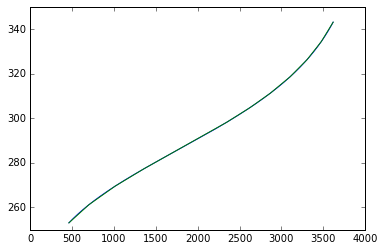

In [28]:
%matplotlib inline

# Ramer-Douglas-Peucker Algorithm implementation from
# git@github.com:fhirschmann/rdp.git
from rdp import rdp

class Thermistor(object):
    def __init__(self, r0=100000, beta=3950, t0=298.15, r_sense=136000):
        self.r0 = r0 # Ohm
        self.beta = beta
        self.t0 = t0 # Kelvin
        self.r_sense = r_sense # Ohm

        self.r_inf = self.r0 * numpy.e ** -(self.beta / self.t0)

    def temp(self, v_adc):
        """
        Accept ADC value from thermistor connected to ADC_IN0.
        Return temperature in Kelvin
        """
        return self.beta / numpy.log(
            self.r_sense / self.r_inf * (float(0xfff) / v_adc - 1)
        )

    def resistance(self, temp):
        """
        Calculate resistance of a thermistor based on temperature
        """
        return self.r_inf * (numpy.e ** (self.beta/temp))

    def temp_approximation(self, adc_start=100, adc_stop=3900, epsilon=0.3):
        """
        Calculate linear approximation to temperature curve for a range of
        ADC values.
        """
        adc_values = numpy.arange(adc_start, adc_stop)
        temperature = self.temp(adc_values)
        return (adc_values, temperature, rdp(zip(adc_values, temperature), epsilon=epsilon))

# I probably need to put a trimmer to get exact value of 136KOhm, but I didn't have suitable one
# so I have put a pair of 67KOhm in series. Close enough to the optimum.
actual_sense_value = 67000 * 2 
adc_stop = int( sense.voltage(actual_sense_value, sense.thermo_range[0]) * 0xfff / sense.vdd )
adc_start = int( sense.voltage(actual_sense_value, sense.thermo_range[1]) * 0xfff / sense.vdd )

thermo = Thermistor(r_sense=actual_sense_value)
(adc_clicks, temperature, temp_approx) = thermo.temp_approximation(adc_start, adc_stop)
plt.plot(adc_clicks, temperature)
plt.plot([v[0] for v in temp_approx], [v[1] for v in temp_approx])

import pprint
pprint.pprint(temp_approx)

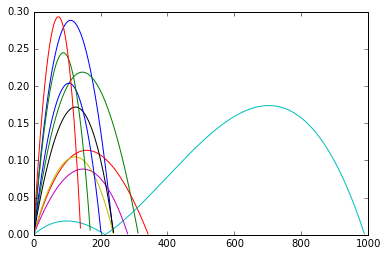

In [27]:
for (start_x, start_y), (end_x, end_y) in zip(temp_approx, temp_approx[1:]):
    axis = np.arange(start_x, end_x)
    delta = np.abs(np.interp(axis, [start_x, end_x], [start_y, end_y]) - 
                   thermo.temp(axis))
    plt.plot(delta)     

As expected, the error does not exceed 0.3 degrees. More than enough for my needs!

## Lets Implement!

> Note: The latest and greatest is in the [thermo github repository](https://github.com/kloper/thermo/blob/master/src/steinhart.c)